In [1]:
import numpy as np
import pandas as pd
from SWMM import SWMM_ENV as SWMM_ENV
from PPO import PPO as PPO
import datetime
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from swmm_api import read_out_file
import os

# Rainfalls

In [2]:
os.chdir(os.path.pardir)
os.chdir('./step0-knowledge/')
raindata = np.load('./rainfall/normlized_rainfall.npy',allow_pickle=True).tolist()
#exraindata = np.load('./rainfall/normlized_extended_rainfall.npy',allow_pickle=True).tolist()
exraindata = np.load('./rainfall/normlized_realrainfall.npy',allow_pickle=True).tolist()
os.chdir(os.path.pardir)
os.chdir('./step3-LFS/')

# Env

In [3]:
env_params = {
    'orf':'./SWMM/chaohu',
    'orf_save':'chaohu_RTC',# opt中使用不同的inp计算，上两个参数没有用到
    'parm':'./states_yaml/chaohu',
    'advance_seconds':300,
    'kf':1,
    'kc':1,
    'reward_type':'3',
}
env3=SWMM_ENV.SWMM_ENV(env_params)

# PPO results

In [4]:
def PPO_interact(model,i,env,raindata):
    observation, episode_return, episode_length = env.reset(raindata,i,False,os.getcwd()), 0, 0
    done, t= False, 0
    while not done:
        observation = np.array(observation).reshape(1, -1)
        logits, action = PPO.sample_action(observation,model,False)
        at=model.action_table[int(action[0].numpy())].tolist()
        observation_new,reward,results,done = env.step(at)
        observation = observation_new
    return env.results

In [5]:
agent_params={
    'state_dim':len(env3.config['states']),
    'action_dim':pd.read_csv('./SWMM/action_table.csv').values[:,1:].shape[0],
    'actornet_layer':[50,50,50],
    'criticnet_layer':[50,50,50],
    
    'bound_low':0,
    'bound_high':1,
    
    'clip_ratio':0.01,
    'target_kl':0.03,
    'lam':0.01,
    
    'policy_learning_rate':0.001,
    'value_learning_rate':0.001,
    'train_policy_iterations':50,
    'train_value_iterations':50,
    
    'num_rain':50,
    
    'training_step':501,
    'gamma':0.01,
    'epsilon':1,
    'ep_min':1e-50,
    'ep_decay':0.1,

    'action_table':pd.read_csv('SWMM/action_table.csv').values[:,1:],
}

model3 = PPO.PPO(agent_params)
model3.load_model('Results_PPO_reward3/model')

In [6]:
# the first 4 rainfalls and real rainfalls, results_PPO_1, results_PPO_2, results_PPO_3
for i in range(91):
    #results_PPO_r1['rainfall'+str(i)] = {}
    #results_PPO_r2['rainfall'+str(i)] = {}
    results_PPO_r3 = PPO_interact(model3,i,env3,raindata)
    np.save('./results/ppo_results_rain'+str(i)+'.npy',results_PPO_r3)

# extended rainfall
for i in range(len(exraindata)):
    #results_PPO_r1['rainfall'+str(i)] = {}
    #results_PPO_r2['rainfall'+str(i)] = {}
    results_PPO_r3 = PPO_interact(model3,i,env3,exraindata)
    np.save('./results/extended_ppo_results_rain'+str(i)+'.npy',results_PPO_r3)

In [6]:
# real rainfall
for i in range(len(exraindata)):
    #results_PPO_r1['rainfall'+str(i)] = {}
    #results_PPO_r2['rainfall'+str(i)] = {}
    results_PPO_r3 = PPO_interact(model3,i,env3,exraindata)
    np.save('./results/real_ppo_results_rain'+str(i)+'.npy',results_PPO_r3)

# Check results

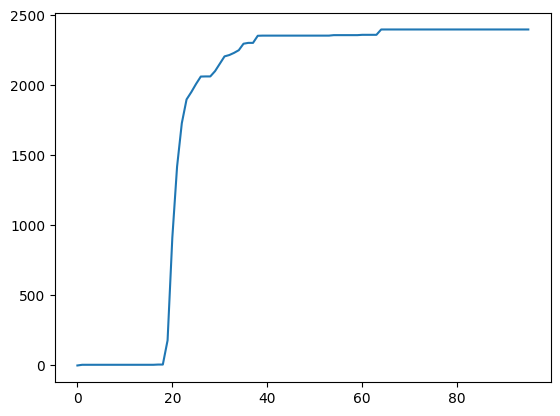

In [8]:
plt.plot(results_PPO_r3['flooding'])